<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Basic-cleaning" data-toc-modified-id="Basic-cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic cleaning</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Univariate-analysis" data-toc-modified-id="Univariate-analysis-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Univariate analysis</a></span></li><li><span><a href="#Bivariate-analysis" data-toc-modified-id="Bivariate-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Bivariate analysis</a></span></li></ul></li><li><span><a href="#Feature-Enginnering" data-toc-modified-id="Feature-Enginnering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Enginnering</a></span><ul class="toc-item"><li><span><a href="#Mapping-target-and-split-X-and-y" data-toc-modified-id="Mapping-target-and-split-X-and-y-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mapping target and split X and y</a></span></li><li><span><a href="#Preprocessing-pipeline" data-toc-modified-id="Preprocessing-pipeline-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Preprocessing pipeline</a></span></li></ul></li><li><span><a href="#Logistic-Regression---baseline" data-toc-modified-id="Logistic-Regression---baseline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Logistic Regression - baseline</a></span></li><li><span><a href="#Advanced-Model-(Random-Forest)" data-toc-modified-id="Advanced-Model-(Random-Forest)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Advanced Model (Random Forest)</a></span><ul class="toc-item"><li><span><a href="#Advance-Model-(xgb)" data-toc-modified-id="Advance-Model-(xgb)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Advance Model (xgb)</a></span></li><li><span><a href="#Cost-based-optimisation" data-toc-modified-id="Cost-based-optimisation-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Cost based optimisation</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

RANDOM_STATE = 42
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## Load data

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Basic cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Strip spaces from all string columns (safe + prevents hidden " ")
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Convert TotalCharges properly (blank -> NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Optional: convert SeniorCitizen to numeric if it came as object (rare)
df["SeniorCitizen"] = pd.to_numeric(df["SeniorCitizen"], errors="coerce")



In [5]:
df[["TotalCharges", "SeniorCitizen", "tenure", "MonthlyCharges"]].dtypes
df["TotalCharges"].isna().sum()

np.int64(11)

## EDA

In [6]:
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

### Univariate analysis

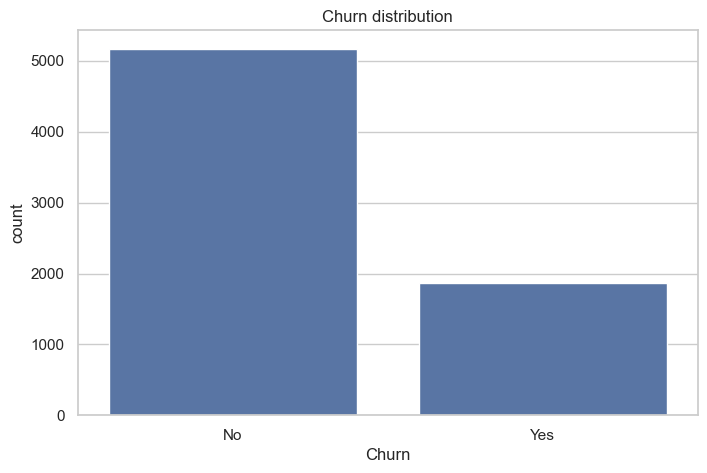

In [7]:
sns.countplot(data=df, x="Churn")
plt.title("Churn distribution")
plt.show()

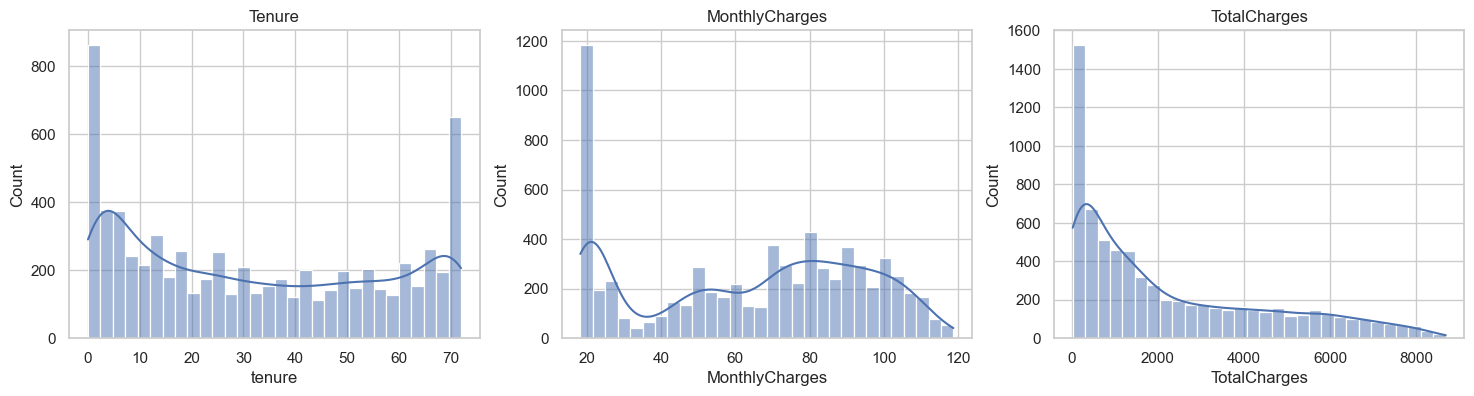

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df["tenure"], bins=30, kde=True, ax=axes[0]); axes[0].set_title("Tenure")
sns.histplot(df["MonthlyCharges"], bins=30, kde=True, ax=axes[1]); axes[1].set_title("MonthlyCharges")
sns.histplot(df["TotalCharges"], bins=30, kde=True, ax=axes[2]); axes[2].set_title("TotalCharges")
plt.show()

### Bivariate analysis

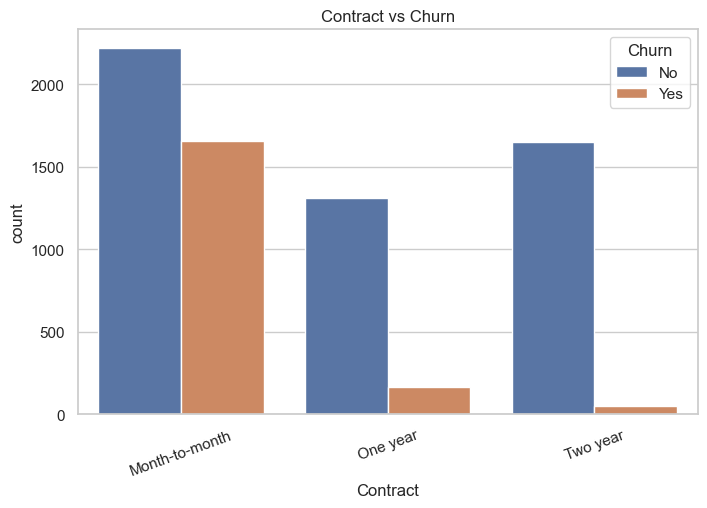

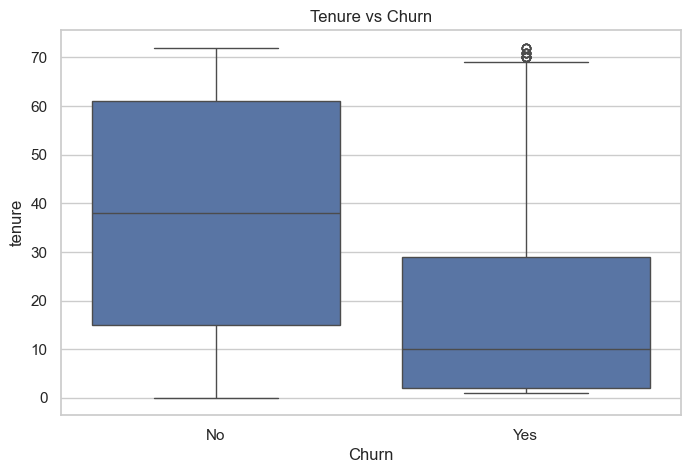

In [9]:
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Contract vs Churn")
plt.xticks(rotation=20)
plt.show()

sns.boxplot(data=df, x="Churn", y="tenure")
plt.title("Tenure vs Churn")
plt.show()


## Feature Enginnering

### Mapping target and split X and y

In [10]:
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["customerID", "Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

### Preprocessing pipeline

In [11]:
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

## Logistic Regression - baseline

ROC-AUC: 0.8412978893797307
Accuracy: 0.7381121362668559
Precision: 0.504302925989673
Recall: 0.7834224598930482
F1: 0.6136125654450262

Confusion matrix:
 [[747 288]
 [ 81 293]]

Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



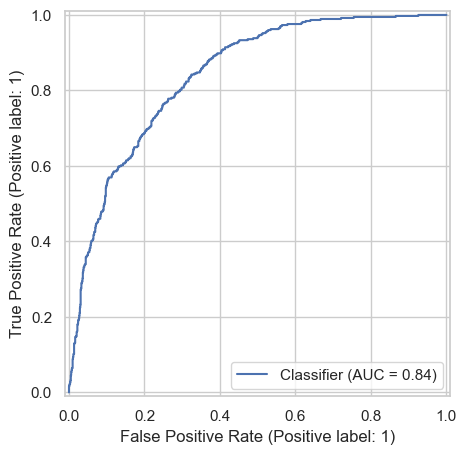

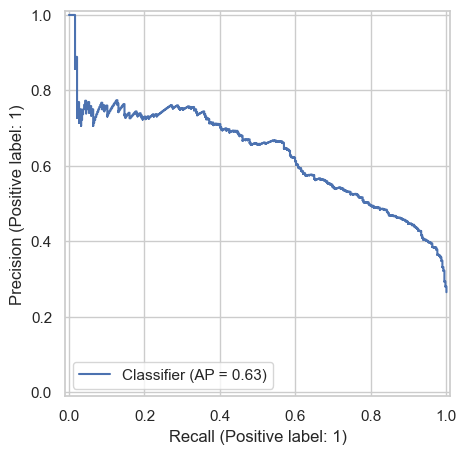

In [12]:
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

baseline.fit(X_train, y_train)

y_proba = baseline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()


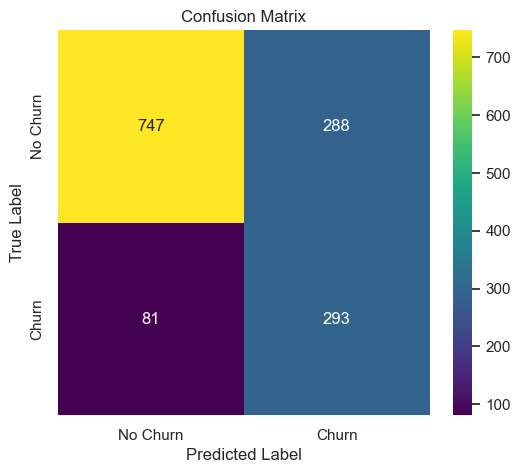

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='viridis',
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Class 0 (Non-Churn Customers)**

Precision = 0.90

When the model predicted someone will NOT churn, it is correct 90% of the time.


Recall = 0.72

Out of all true non-churners, the model correctly identifies 72%.

So it wrongly flags 28% of loyal customers as churn risk.

This means:

Some safe customers are being unnecessarily targeted.

**Class 1 (Churn Customers — the important one)**

Precision = 0.50

When the model predicts someone will churn, it is correct only 50% of the time.

So half of company's retention efforts would be wasted.

Recall = 0.78

Out of all actual churners, the model correctly catches 78%.

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    average_precision_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay
)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
import xgboost
print(xgboost.__version__)

3.2.0


## Advanced Model (Random Forest)

In [22]:
df = pd.read_csv('Telco-Customer-Churn.csv')

print(df.shape)

# Strip spaces in all object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["SeniorCitizen"] = pd.to_numeric(df["SeniorCitizen"], errors="coerce")


(7043, 21)


In [23]:
y = df["Churn"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["customerID", "Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [24]:
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [26]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

param_dist = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [None, 4, 6, 8, 12],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best CV ROC-AUC:", search.best_score_)
print("Best params:\n", search.best_params_)
best_model = search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CV ROC-AUC: 0.8473176960175313
Best params:
 {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 8}


In [27]:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Test PR-AUC:", average_precision_score(y_test, y_proba))
print("\nReport:\n", classification_report(y_test, y_pred))

Test ROC-AUC: 0.8419837763827535
Test PR-AUC: 0.6485971987174972

Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



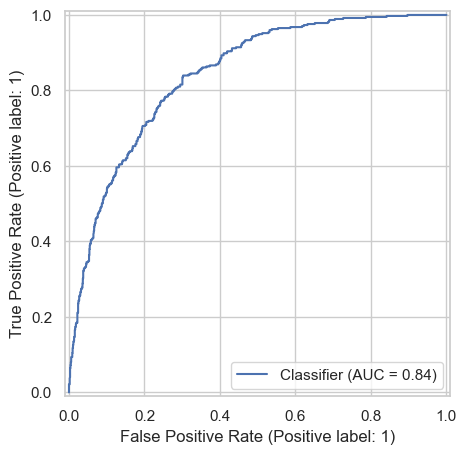

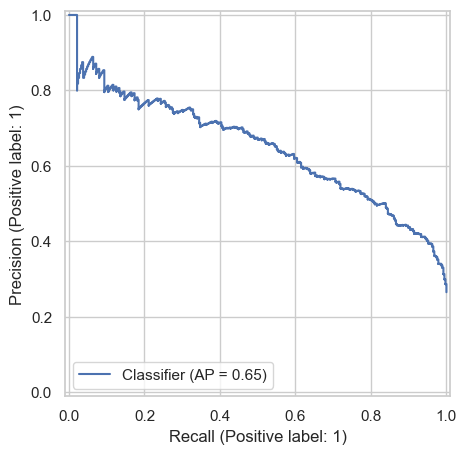

In [28]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()

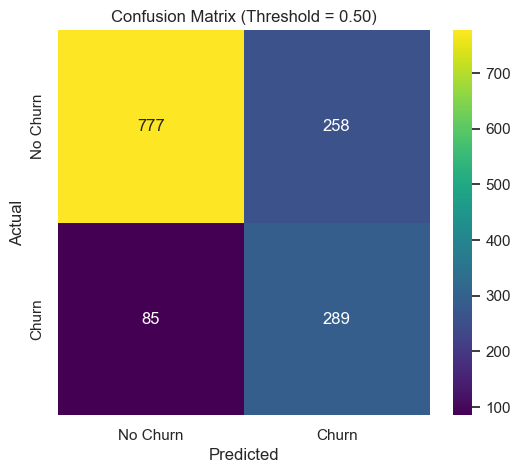

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.show()


In [30]:
thresholds = np.linspace(0.1, 0.9, 17)
rows = []

for t in thresholds:
    pred_t = (y_proba >= t).astype(int)
    report = classification_report(y_test, pred_t, output_dict=True)
    rows.append({
        "threshold": t,
        "precision_churn": report["1"]["precision"],
        "recall_churn": report["1"]["recall"],
        "f1_churn": report["1"]["f1-score"]
    })

thr_df = pd.DataFrame(rows).sort_values("f1_churn", ascending=False)
thr_df.head(10)

,threshold,precision_churn,recall_churn,f1_churn
8,0.50,0.528336,0.772727,0.627579
9,0.55,0.556017,0.716578,0.626168
7,0.45,0.507589,0.804813,0.622544
6,0.40,0.485407,0.844920,0.616585
10,0.60,0.571759,0.660428,0.612903
11,0.65,0.609626,0.609626,0.609626
5,0.35,0.460770,0.863636,0.600930
4,0.30,0.436129,0.903743,0.588338
12,0.70,0.659933,0.524064,0.584203
3,0.25,0.415971,0.933155,0.575433


In [33]:
best_t = thr_df.iloc[7]["threshold"]
best_t

np.float64(0.30000000000000004)

In [34]:
y_pred_t = (y_proba >= best_t).astype(int)
print(classification_report(y_test, y_pred_t))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      1035
           1       0.44      0.90      0.59       374

    accuracy                           0.66      1409
   macro avg       0.69      0.74      0.65      1409
weighted avg       0.81      0.66      0.68      1409



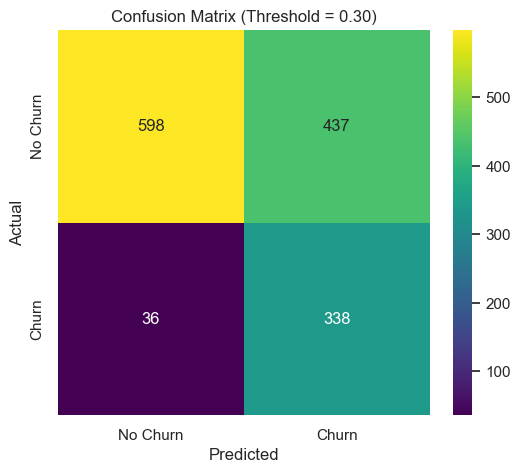

In [37]:
cm = confusion_matrix(y_test, y_pred_t)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.30)")
plt.show()

In [38]:
best_t = thr_df.iloc[9]["threshold"]
best_t

np.float64(0.25)

In [39]:
y_pred_t2 = (y_proba >= best_t).astype(int)
print(classification_report(y_test, y_pred_t2))

              precision    recall  f1-score   support

           0       0.96      0.53      0.68      1035
           1       0.42      0.93      0.58       374

    accuracy                           0.63      1409
   macro avg       0.69      0.73      0.63      1409
weighted avg       0.81      0.63      0.65      1409



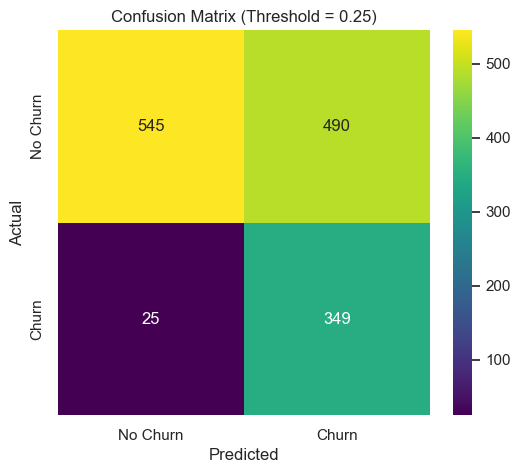

In [40]:
cm = confusion_matrix(y_test, y_pred_t2)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.25)")
plt.show()

**Want catch more churners** -> choose higher recall

**Want less wasted discount** -> choose higher precision

### Advance Model (xgb)

In [42]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric="logloss"
    ))
])

xgb_pipe.fit(X_train, y_train)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

print("XGB Test ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
print("XGB PR-AUC:", average_precision_score(y_test, y_proba_xgb))


XGB Test ROC-AUC: 0.8355976646257977
XGB PR-AUC: 0.6458920006019575


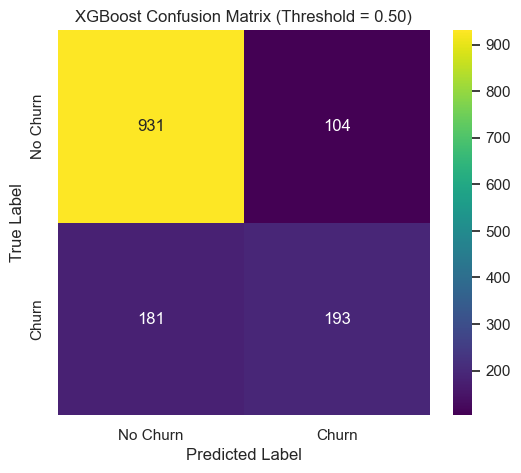

In [47]:
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int) 
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix (Threshold = 0.50)")
plt.show()

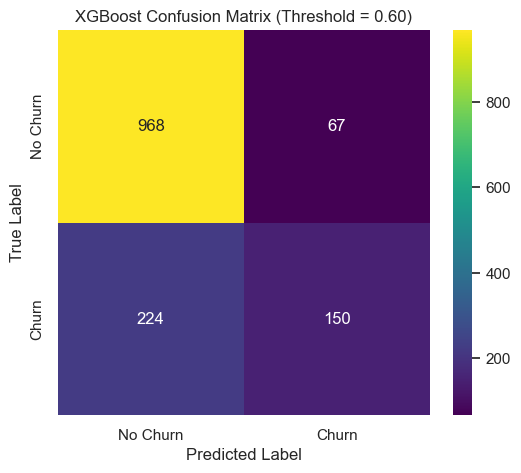

In [49]:
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.6).astype(int) 
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix (Threshold = 0.60)")
plt.show()

In [57]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1035
           1       0.69      0.40      0.51       374

    accuracy                           0.79      1409
   macro avg       0.75      0.67      0.69      1409
weighted avg       0.78      0.79      0.77      1409



In [58]:
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.25).astype(int)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [50]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": make_scorer(f1_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score),
}

models = {
    "LogReg_balanced": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]),
    
    "RF_balanced": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=500,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=1  # avoid Windows parallel issue
        ))
    ]),
    
    "XGB": Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            eval_metric="logloss"
        ))
    ])
}

rows = []

for name, pipe in models.items():
    print(f"Running CV for: {name}")
    
    out = cross_validate(
        pipe,
        X,
        y,
        cv=cv,
        scoring=scoring,
        n_jobs=1  # safer on Windows
    )
    
    rows.append({
        "model": name,
        "roc_auc_mean": out["test_roc_auc"].mean(),
        "pr_auc_mean": out["test_pr_auc"].mean(),
        "f1_mean": out["test_f1"].mean(),
        "recall_mean": out["test_recall"].mean(),
        "precision_mean": out["test_precision"].mean(),
    })

comparison_df = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)

comparison_df

Running CV for: LogReg_balanced
Running CV for: RF_balanced
Running CV for: XGB


,model,roc_auc_mean,pr_auc_mean,f1_mean,recall_mean,precision_mean
0,LogReg_balanced,0.844875,0.655381,0.625824,0.801484,0.513362
2,XGB,0.836751,0.644785,0.574692,0.523248,0.637660
1,RF_balanced,0.821593,0.605548,0.539067,0.470281,0.632140


Best: Logistic Regression (0.8449)
Second: XGBoost
Third: Random Forest

This means:

Logistic regression ranks churners vs non-churners best overall.

Since churn is only ~26%, PR-AUC is very important.

Best: LogReg (0.655)
Second: XGB (0.645)
Third: RF (0.605)

Logistic Regression catches: 80% of churners

XGB only catches: 52%

RF catches: 47%


LogReg:

High recall

Lower precision

XGB/RF:

Higher precision

Much lower recall

If the  goal is:
Catch as many churners as possible: Choose Logistic Regression

Avoid wasting retention budget: Choose XGBoost

### Cost based optimisation 

In [52]:
final_logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

final_logreg.fit(X_train, y_train)

y_proba_lr = final_logreg.predict_proba(X_test)[:, 1]

In [53]:
benefit_tp = 200   # profit saved if churner retained
cost_fp = 30       # cost of unnecessary retention offer
cost_fn = 200      # lost profit if churner missed

In [54]:
def best_threshold_by_cost(y_true, y_proba, benefit_tp, cost_fp, cost_fn):
    
    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        profit = (tp * benefit_tp) - (fp * cost_fp) - (fn * cost_fn)
        
        rows.append({
            "threshold": t,
            "profit": profit,
            "TP": tp,
            "FP": fp,
            "FN": fn,
            "TN": tn
        })
    
    df_profit = pd.DataFrame(rows).sort_values("profit", ascending=False)
    
    return df_profit

profit_table = best_threshold_by_cost(
    y_test,
    y_proba_lr,
    benefit_tp,
    cost_fp,
    cost_fn
)

profit_table.head(10)

,threshold,profit,TP,FP,FN,TN
2,0.15,52360,365,628,9,407
3,0.20,52220,360,566,14,469
1,0.10,51720,370,716,4,319
4,0.25,50300,351,510,23,525
5,0.30,50140,347,462,27,573
0,0.05,49040,372,832,2,203
6,0.35,48260,339,418,35,617
7,0.40,43670,324,371,50,664
8,0.45,40350,313,335,61,700
9,0.50,33760,293,288,81,747


In [55]:
y_pred_best = (y_proba_lr >= best_t).astype(int)

print("Best Threshold:", best_t)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_best))

Best Threshold: 0.25

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.51      0.66      1035
           1       0.41      0.94      0.57       374

    accuracy                           0.62      1409
   macro avg       0.68      0.72      0.62      1409
weighted avg       0.81      0.62      0.64      1409



**Recall (Churn) = 0.94**

We are catching 94% of churners.

That means:
Out of 374 churners,
We miss only about 6%.

**Precision (Churn) = 0.41**

When the model predicts churn,
Only 41% actually churn.

So 59% of retention actions are unnecessary.

**Precision (No Churn) = 0.96**

If the model says someone will stay,
It is correct 96% of the time.

Very reliable at predicting loyalty.

**Recall (No Churn) = 0.51**

But it only correctly identifies 51% of loyal customers.

This means:
It is labeling many loyal customers as churn risk.

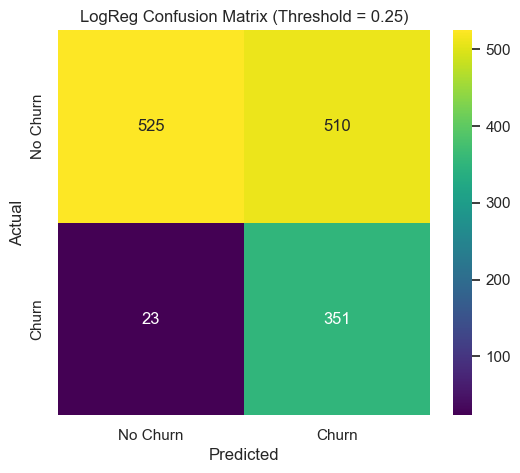

In [56]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.title(f"LogReg Confusion Matrix (Threshold = {best_t:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We selected the threshold that maximizes expected profit based on estimated retention cost and churn loss. This resulted in an optimal threshold of X, increasing expected net profit to Y.